In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel("./data/data_processed.xlsx", index_col=[0, 1])
df

D401      D403      D405      D407      D409  \
GROUP     IDcard                                                         
Control   CG1_1       0.429949  0.415618  0.448580  0.454313  0.454313   
          CG1_2       0.394105  0.411516  0.421012  0.419429  0.435257   
          CG1_3       0.387310  0.375419  0.395804  0.399201  0.409394   
          CG1_4       0.377452  0.372186  0.391497  0.373941  0.400275   
          CG1_5       0.361116  0.382675  0.384472  0.389861  0.398844   
...                        ...       ...       ...       ...       ...   
Parkinson БП007(П)_4  0.399589  0.413402  0.420309  0.435108  0.435108   
          БП007(П)_5  0.400590  0.417446  0.414471  0.432319  0.442235   
          БП007(П)_6  0.390591  0.395599  0.412625  0.426646  0.442670   
          БП007(П)_7  0.394252  0.406290  0.428360  0.429364  0.432373   
          БП007(П)_8  0.408528  0.410545  0.417606  0.431728  0.436772   

                          D410      D412      D414      D416      D418  ...  \
GROUP     IDcard                                                        ...   
Control   CG1_1       0.484409  0.487276  0.513073  0.518805  0.544602  ...   
          CG1_2       0.451084  0.457415  0.477991  0.492236  0.504898  ...   
          CG1_3       0.424682  0.439971  0.465452  0.480740  0.489234  ...   
          CG1_4       0.405542  0.430120  0.442409  0.461721  0.458210  ...   
          CG1_5       0.400641  0.445556  0.447352  0.456335  0.477895  ...   
...                        ...       ...       ...       ...       ...  ...   
Parkinson БП007(П)_4  0.460761  0.466681  0.489374  0.501213  0.530813  ...   
          БП007(П)_5  0.454134  0.475948  0.492805  0.513627  0.528501  ...   
          БП007(П)_6  0.452685  0.463702  0.484734  0.508770  0.529802  ...   
          БП007(П)_7  0.454443  0.462469  0.486545  0.501593  0.518647  ...   
          БП007(П)_8  0.448876  0.471068  0.484181  0.505364  0.529573  ...   

                          I659      I661      I663      I665      I667  \
GROUP     IDcard                                                         
Control   CG1_1       0.162155  0.146725  0.150032  0.142317  0.133500   
          CG1_2       0.158358  0.157105  0.144576  0.148335  0.128288   
          CG1_3       0.167908  0.162235  0.140959  0.150887  0.148051   
          CG1_4       0.171480  0.151769  0.147221  0.156318  0.139640   
          CG1_5       0.169657  0.157000  0.158582  0.136433  0.141179   
...                        ...       ...       ...       ...       ...   
Parkinson БП007(П)_4  0.103691  0.096881  0.101137  0.102840  0.096881   
          БП007(П)_5  0.113966  0.106218  0.112244  0.103636  0.094166   
          БП007(П)_6  0.106001  0.102497  0.095487  0.109506  0.102497   
          БП007(П)_7  0.104432  0.106193  0.100911  0.107073  0.101792   
          БП007(П)_8  0.118068  0.099456  0.112751  0.096797  0.105660   

                          I669      I671      I673      I674      I676  
GROUP     IDcard                                                        
Control   CG1_1       0.123580  0.125785  0.123580  0.121376  0.130193  
          CG1_2       0.130794  0.124530  0.125782  0.117012  0.125782  
          CG1_3       0.136704  0.114009  0.122520  0.133867  0.138122  
          CG1_4       0.135091  0.132059  0.135091  0.133575  0.147221  
          CG1_5       0.131687  0.120612  0.114284  0.117448  0.136433  
...                        ...       ...       ...       ...       ...  
Parkinson БП007(П)_4  0.089219  0.091773  0.084111  0.085814  0.079854  
          БП007(П)_5  0.084696  0.083836  0.087279  0.083836  0.094166  
          БП007(П)_6  0.094611  0.085850  0.082345  0.084098  0.088478  
          БП007(П)_7  0.094749  0.069221  0.092108  0.080665  0.091228  
          БП007(П)_8  0.089707  0.087048  0.088821  0.085276  0.089707  

[512 rows x 294 columns]

In [27]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X = df.loc[:, "D401":"D676"].copy()
y = pd.Series([1 if x == "Parkinson" else 0 for x in df.index.get_level_values("GROUP").to_list()], index = df.index)
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.4, random_state=33)

clf = SVC(class_weight="balanced", probability=True)
clf.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True)

In [23]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

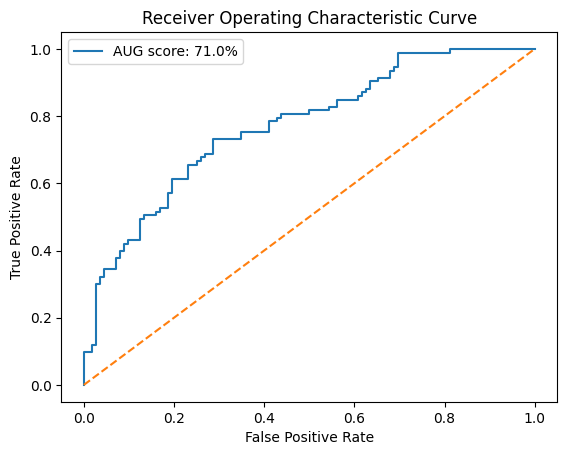

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
def draw_infograph(clf, y_true, proba, y_pred):
    score = roc_auc_score(y_true, y_pred)
    fpr, tpr, _= roc_curve(y_true, proba, pos_label=1)

    plt.plot(fpr, tpr)
    plt.plot ([0, 1], [0, 1], linestyle='--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title("Receiver Operating Characteristic Curve")
    plt.legend([f"AUG: {score * 100 :.1f}%"])

y_pred = clf.predict(X_val)
proba = clf.predict_proba(X_val)[:, 1]
draw_infograph(clf, y_val, proba, y_pred)